In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

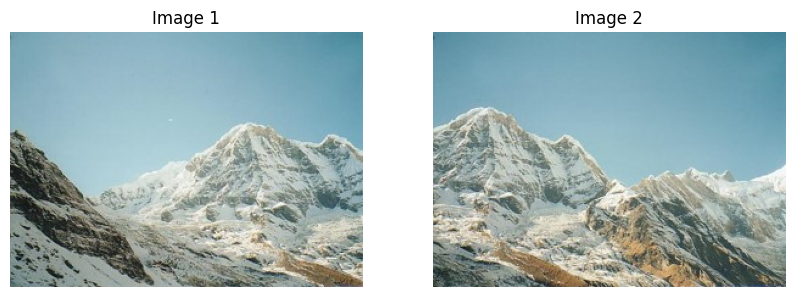

In [2]:
ImageA = cv2.imread('image1.jpg')
ImageB = cv2.imread('image2.jpg')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cv2.cvtColor(ImageA, cv2.COLOR_BGR2RGB))
axes[0].set_title('Image 1')
axes[1].imshow(cv2.cvtColor(ImageB, cv2.COLOR_BGR2RGB))
axes[1].set_title('Image 2')
for ax in axes:
    ax.axis('off')
plt.show()

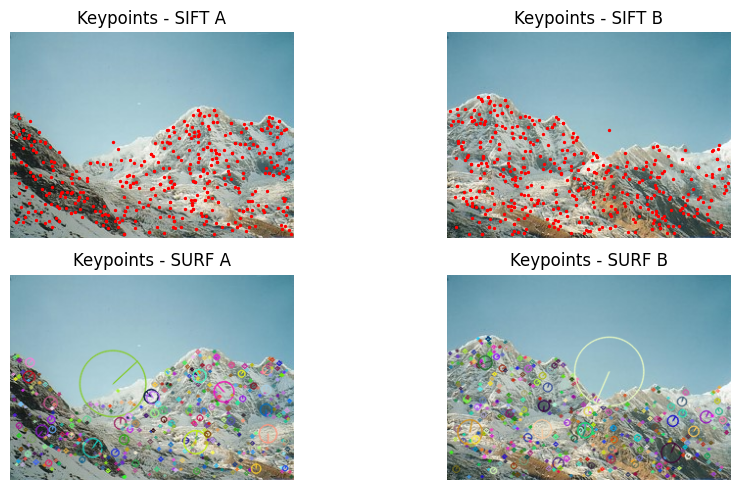

In [3]:
def SIFT(image):
    detector = cv2.SIFT_create()
    keypoints, descriptors = detector.detectAndCompute(image, None)
    return keypoints, descriptors

def SURF(image):
    detector = cv2.SURF_create()
    keypoints, descriptors = detector.detectAndCompute(image, None)
    return keypoints, descriptors

SIFT_KEYPOINTS_A, SIFT_DESCRIPTORS_A = SIFT(ImageA)
SIFT_KEYPOINTS_B, SIFT_DESCRIPTORS_B = SIFT(ImageB)

SURF_KEYPOINTS_A, SURF_DESCRIPTORS_A = SIFT(ImageA)
SURF_KEYPOINTS_B, SURF_DESCRIPTORS_B = SIFT(ImageB)

fig, axes = plt.subplots(2, 2, figsize=(10, 5))
# SIFT
axes[0, 0].imshow(cv2.cvtColor(ImageA, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('Keypoints - SIFT A')
axes[0, 0].scatter([kp.pt[0] for kp in SIFT_KEYPOINTS_A], [kp.pt[1] for kp in SIFT_KEYPOINTS_A], c='red', marker='o', s=2)
axes[0, 0].axis('off')

axes[0, 1].imshow(cv2.cvtColor(ImageB, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title('Keypoints - SIFT B')
axes[0, 1].scatter([kp.pt[0] for kp in SIFT_KEYPOINTS_B], [kp.pt[1] for kp in SIFT_KEYPOINTS_B], c='red', marker='o', s=2)
axes[0, 1].axis('off')

# SURF
SURF_IMAGEA = cv2.drawKeypoints(ImageA, SURF_KEYPOINTS_A, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
axes[1, 0].imshow(cv2.cvtColor(SURF_IMAGEA, cv2.COLOR_BGR2RGB))
axes[1, 0].set_title('Keypoints - SURF A')
axes[1, 0].axis('off')

SURF_IMAGEB = cv2.drawKeypoints(ImageB, SURF_KEYPOINTS_B, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
axes[1, 1].imshow(cv2.cvtColor(SURF_IMAGEB, cv2.COLOR_BGR2RGB))
axes[1, 1].set_title('Keypoints - SURF B')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

In [4]:
def arrangePairs(setA, setB):
    arranged_setB = []
    for pointA in setA:
        min_distance = float('inf')
        closest_pointB = None
        for pointB in setB:
            distance = np.linalg.norm(pointA - pointB)
            if distance < min_distance:
                min_distance = distance
                closest_pointB = pointB
        arranged_setB.append(closest_pointB)
    return setA, arranged_setB

def estimateTransformation(setA, setB):
    num_points = len(setA)
    A = np.zeros((2 * num_points, 6))
    b = np.zeros((2 * num_points, 1))
    for i in range(num_points):
        A[i * 2] = [setB[i][0], setB[i][1], 0, 0, 1, 0]
        A[i * 2 + 1] = [0, 0, setB[i][0], setB[i][1], 0, 1]
        b[i * 2] = setA[i][0]
        b[i * 2 + 1] = setA[i][1]
    x, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    params = x.flatten()
    T = np.array([[params[0], params[1], params[4]],[params[2], params[3], params[5]],[0, 0, 1]])
    return T

def apply_transformation(transformation_matrix, SIFT_KEYPOINTS_A):
    if isinstance(SIFT_KEYPOINTS_A, list) and hasattr(SIFT_KEYPOINTS_A[0], 'pt'):
        SIFT_KEYPOINTS_A = np.float32([kp.pt for kp in SIFT_KEYPOINTS_A])
    set_homogeneous = np.hstack((SIFT_KEYPOINTS_A, np.ones((len(SIFT_KEYPOINTS_A), 1))))
    transformed_set = np.dot(set_homogeneous, transformation_matrix.T)
    transformed_set[:, 0] /= transformed_set[:, 2]
    transformed_set[:, 1] /= transformed_set[:, 2]
    transformed_set = transformed_set[:, :2]
    return transformed_set

In [5]:
def ransac(keypoints1, keypoints2, matches, iterations=1000, threshold=5):
    best_inliers = []
    best_T = None
    for _ in range(iterations):
        sample_indices = np.random.choice(len(matches), 4, replace=False)
        sample_matches = [matches[i] for i in sample_indices]
        A_KP = np.float32([keypoints1[m.queryIdx].pt for m in sample_matches]).reshape(-1, 2)
        B_KP = np.float32([keypoints2[m.trainIdx].pt for m in sample_matches]).reshape(-1, 2)
        T = estimateTransformation(A_KP, B_KP)
        inliers = []
        for i, match in enumerate(matches):
            src_pt = np.float32(keypoints1[match.queryIdx].pt).reshape(-1, 2)
            dst_pt = np.float32(keypoints2[match.trainIdx].pt).reshape(-1, 2)
            transformed_matrix = apply_transformation(T, dst_pt)
            distance = np.linalg.norm(src_pt - transformed_matrix)
            if distance < threshold:
                inliers.append(match)
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_T = T
    return best_T, best_inliers


In [6]:
matcher = cv2.BFMatcher()
matcher_matches = matcher.match(SIFT_DESCRIPTORS_A, SIFT_DESCRIPTORS_B)
transformation_matrix, inliers = ransac(SIFT_KEYPOINTS_A, SIFT_KEYPOINTS_B, matcher_matches)
print("Estimated Transformation Matrix:\n", transformation_matrix)
print("Inliers:", inliers)

Estimated Transformation Matrix:
 [[  1.00187605   0.17823695 139.22001879]
 [ -0.15314927   0.98811379  19.670218  ]
 [  0.           0.           1.        ]]
Inliers: [< cv2.DMatch 0000029A342F7990>, < cv2.DMatch 0000029A342F7AD0>, < cv2.DMatch 0000029A342F7BD0>, < cv2.DMatch 0000029A342F7C90>, < cv2.DMatch 0000029A342F7D10>, < cv2.DMatch 0000029A342F7D30>, < cv2.DMatch 0000029A342F7D70>, < cv2.DMatch 0000029A342F7DD0>, < cv2.DMatch 0000029A342F7DF0>, < cv2.DMatch 0000029A342F7E10>, < cv2.DMatch 0000029A342F7E30>, < cv2.DMatch 0000029A342F7E50>, < cv2.DMatch 0000029A342F7E90>, < cv2.DMatch 0000029A342F7EB0>, < cv2.DMatch 0000029A342F7F50>, < cv2.DMatch 0000029A342F7F90>, < cv2.DMatch 0000029A342F7FB0>, < cv2.DMatch 0000029A373F37B0>, < cv2.DMatch 0000029A373F37D0>, < cv2.DMatch 0000029A373F3710>, < cv2.DMatch 0000029A373F36D0>, < cv2.DMatch 0000029A373F3670>, < cv2.DMatch 0000029A373F3650>, < cv2.DMatch 0000029A373F3850>, < cv2.DMatch 0000029A373F3870>, < cv2.DMatch 0000029A373F3890

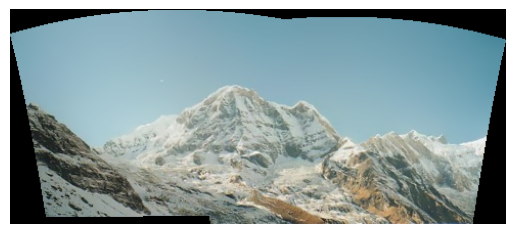

In [7]:
def stitch_images(image1, image2, T):
    height, width = image1.shape[:2]
    warped_image2 = cv2.warpAffine(image2, T[:2], (width, height))
    panorama = cv2.addWeighted(image1, 0.5, warped_image2, 0.5, 0)
    return panorama
 
def create_panorama(images):
    stitcher = cv2.Stitcher_create()
    status, panorama = stitcher.stitch(images)
    if status == cv2.Stitcher_OK:
        return panorama
    
panorama_image = create_panorama([ImageA, ImageB])
if panorama_image is not None:
    plt.imshow(cv2.cvtColor(panorama_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

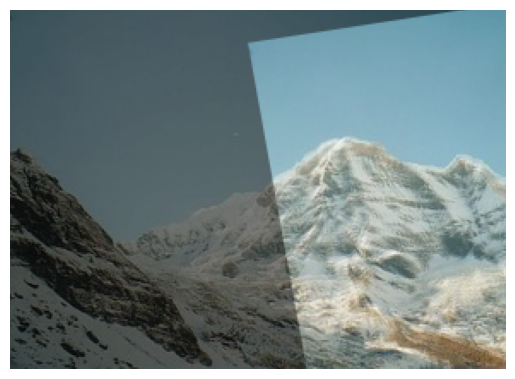

In [8]:
matched_keypoints1 = np.float32([SIFT_KEYPOINTS_A[m.queryIdx].pt for m in inliers])
matched_keypoints2 = np.float32([SIFT_KEYPOINTS_B[m.trainIdx].pt for m in inliers])
arranged_keypoints1, arranged_keypoints2 = arrangePairs(matched_keypoints1, matched_keypoints2)
panorama = stitch_images(ImageA, ImageB, transformation_matrix)
if panorama is not None:
    plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()